# Exploratory Data Analysis

The first step of after cleaning the data is to do some general investigation of the data distribution and identification of patterns, in order to identify the areas and direction that is possible for further investigation.

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Load data
train = pd.read_csv('process_data/train_final.csv', parse_dates=['Date'])
test = pd.read_csv('process_data/test_final.csv', parse_dates=['Date'])
spray = pd.read_csv('raw_data/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('process_data/final_weather.csv', parse_dates=['Date'])

We first check the size of train and test, and the proportion of the cases with/without WNV cases. In the scenario of severe imbalance proportion in the cases, a change in sampling method is required for a more accurate prediction of WNV cases to prevent bias in the model due to the cases proportion.

In [4]:
print("Number of rows in Train:", train.shape[0])
print("Number of rows in Test:", test.shape[0])

Number of rows in Train: 9693
Number of rows in Test: 116293


In [5]:
round(train['WnvPresent'].value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

As we can see above, only 5% of the data given is WNV positive will the rest is all absence of WNV. Training the model in this condition will results in the model to be heavily bias and skewed. The model will more inclined to predict No WNV at all times  as the model will be bias towards the frequency of occurrence rather than the actual correlation of the data features. We will need to use oversampling method like SMOTE in order to balance out the data for training

Next, we check the distribution of WNV carrier among different type of mosquito species to see which if there's any visible trend.

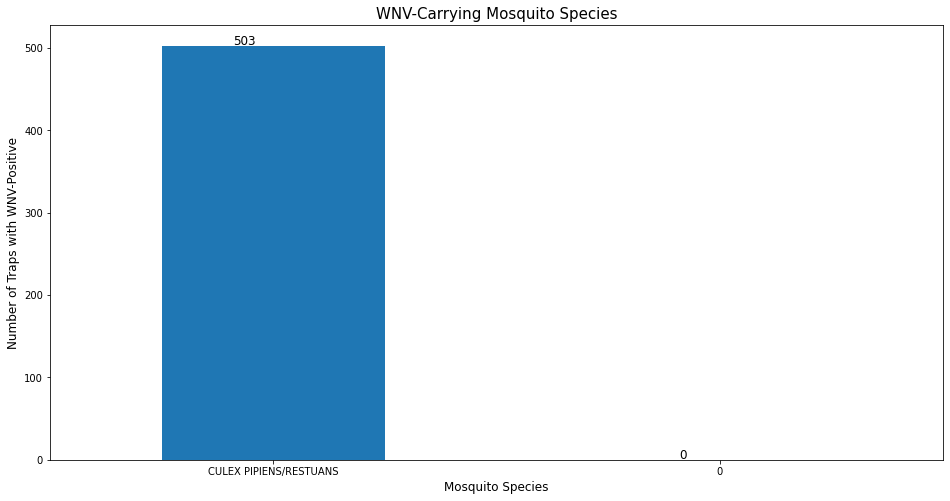

In [6]:
### Comparison of Mosquito Species as WNV Carrier ###
plt.figure(figsize=(16,8))
graph = train.groupby('Species').sum()['WnvPresent'].sort_values(ascending=False)
graph.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Mosquito Species', fontsize=12)
plt.ylabel('Number of Traps with WNV-Positive', fontsize=12)
plt.title('WNV-Carrying Mosquito Species', fontsize=15)

for i in range(len(graph)):
    plt.text(x = i-0.09 , y = graph[i]+1, s = graph[i], size = 12)
    
plt.show()

As shown in the bar chart above, after compiling all detection result of the West Nile Virus among different mosquito species, it is shown that only Culex Pipiens and Culex Restuans mosquitoes are detected to carry the West Nile Virus. The rest of the mosquito species does not carry any West Nile Virus based on the collected data. Therefore we can focused on the 2 mosquito species and exclude the rest when training the model.

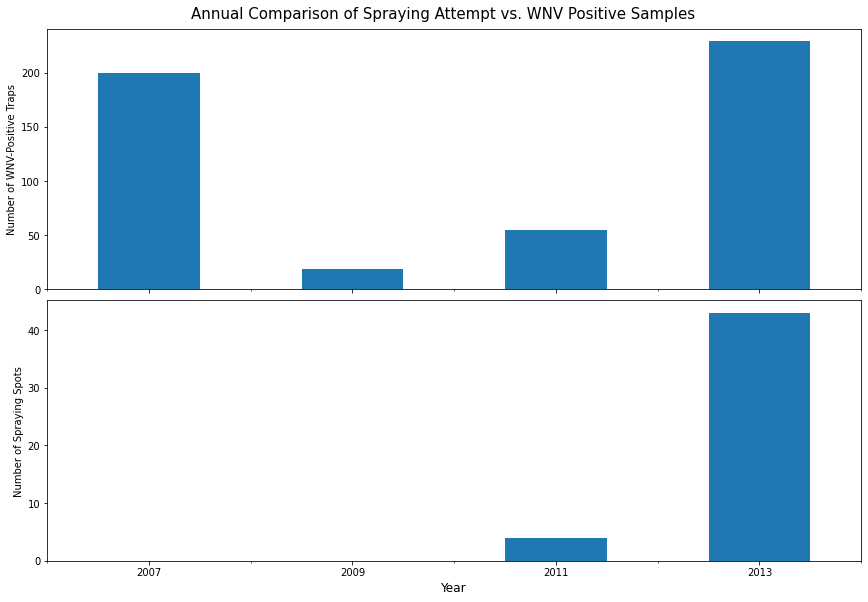

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(12,8), sharex=True)

# Plot 1 - WNV-Positive Trap
train.set_index('Date').resample('2Y').sum()['WnvPresent'].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Number of WNV-Positive Traps')

# Plot 2 - Spraying
train.set_index('Date').resample('2Y').sum()['Sprayed'].plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('Number of Spraying Spots')

# Global Setting
plt.xticks(range(4), ['2007', '2009', '2011', '2013'], rotation=0)
plt.xlabel('Year', fontsize=12)
plt.tight_layout(pad=0.5)
fig.suptitle('Annual Comparison of Spraying Attempt vs. WNV Positive Samples', x=0.51, y=1.03, fontsize=15)
plt.show()

As shown in bar chart above, there is only spraying data in year 2011 and 2013, so the model will be build by using data during that time period whereby both mosquitoes amount and spray timing is available. 

Next, we'll check if there's any correlation between rainfall against the quantity of WNV cases

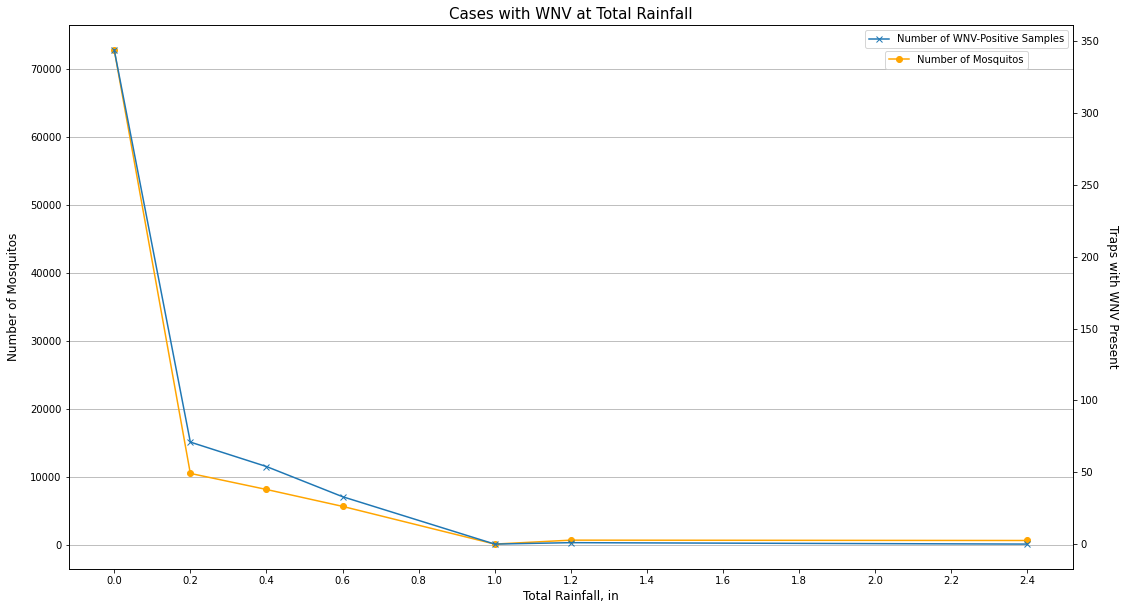

In [8]:
def plot_precip(compound):
    fig, ax = plt.subplots(figsize=(18,10))

    # Compound data to specifed scale
    temp = train.groupby('PrecipTotal').sum()
    temp = temp.groupby(temp.index // compound).sum().reset_index()[['PrecipTotal', 'WnvPresent', 'NumMosquitos']]
    temp.PrecipTotal = temp.PrecipTotal * compound

    # Plot 1 - Mosquitos Count
    temp.set_index('PrecipTotal')['NumMosquitos'].plot(ax=ax, color='orange', marker='o', label='Number of Mosquitos')
    ax.set_ylabel('Number of Mosquitos', fontsize=12, labelpad=10)
    ax.legend(loc=(0.813, 0.92))
    ax.grid(axis='y')

    # Plot 2 - WNV-Positive Traps
    ax2 = ax.twinx()
    temp.set_index('PrecipTotal')['WnvPresent'].plot(ax=ax2, marker='x', label='Number of WNV-Positive Samples')
    ax2.set_ylabel('Traps with WNV Present', fontsize=12, labelpad=20, rotation=270)
    ax2.legend(loc=0)

    # Global Setting
    plt.xticks(np.arange(0, 2.6, 0.2))
    ax.set_xlabel('Total Rainfall, in', fontsize=12)
    plt.title('Cases with WNV at Total Rainfall', fontsize=15)
    plt.show()

plot_precip(compound=0.2)

The line graph shows the rainfall is inversely proportional  to both the number of mosquitoes and number of WNV-positive traps. The numbers are especially high when there is no rainfall at all; while it still thrives at rain amount that is less than 1 inch. After which, the WNV-positive trap counts fell to zero with mosquitoes count hovering around zero as well.

The observation confirms the common understanding of whereby mosquitoes breed in stagnant water. The 0 mosquito count above 1 inch rainfall is most likely due to the case where the heavy downpour eventually cause all stagnant waters to connect and flow to low areas and therefore discouraged breeding.

Next, we plot out the changes in mosquitoes count in each years according to the data. It'll be grouped by weeks and plotted in 4 separate graphs as the data is given in alternate years and not continuous. 

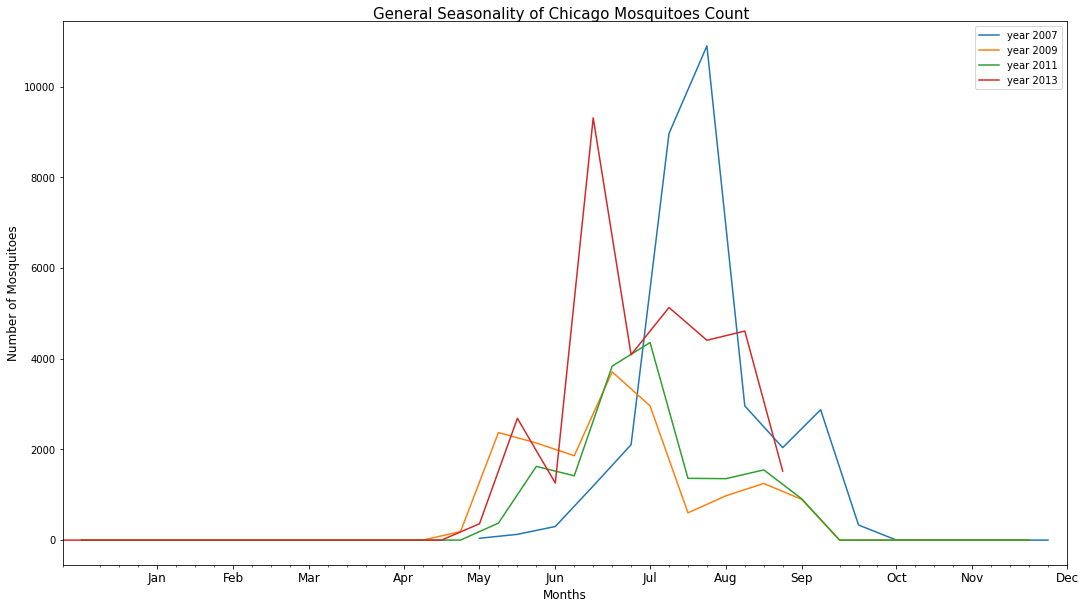

In [9]:
### General Seasonality of Chicago Mosquitoes Count ###
fig, ax = plt.subplots(figsize=(18,10))

# Alternate years in training data
years = ['2007', '2009', '2011', '2013']

mosq_count = train.set_index('Date').resample('2W').sum()['NumMosquitos'].sort_index()

for i in range(4):
    # Plotting one subplot for each alternate-year
    temp = mosq_count[(f'{str(int(years[i])+1)}-01-01'>mosq_count.index)& (mosq_count.index>f'{years[i]}-01-01')]
    temp.index = [a + pd.offsets.DateOffset(years=6-(i*2)) for a in temp.index]
    temp.plot(label=f'year {years[i]}')
    
fig.suptitle('General Seasonality of Chicago Mosquitoes Count', x=0.51, y=0.9, fontsize=15)

ax.set_ylabel('Number of Mosquitoes', fontsize=12)
ax.set_xlabel("Months", fontsize=12)
timeframe = pd.date_range('2013-01-01', '2014-01-01', freq='1M')
plt.xticks(ticks=timeframe, labels=[x.strftime('%b') for x in timeframe], fontsize=12)
plt.legend()
plt.show()

As we can see from the graphs above, generally mosquitoes are only around the area in certain period of the year. The period starts around June and generally ends before November. We can also see it usually reaches its peak after 2 months upon first detection. Next we'll be plotting out the distribution of mosquitoes and rainfall to see if there's any correlation.

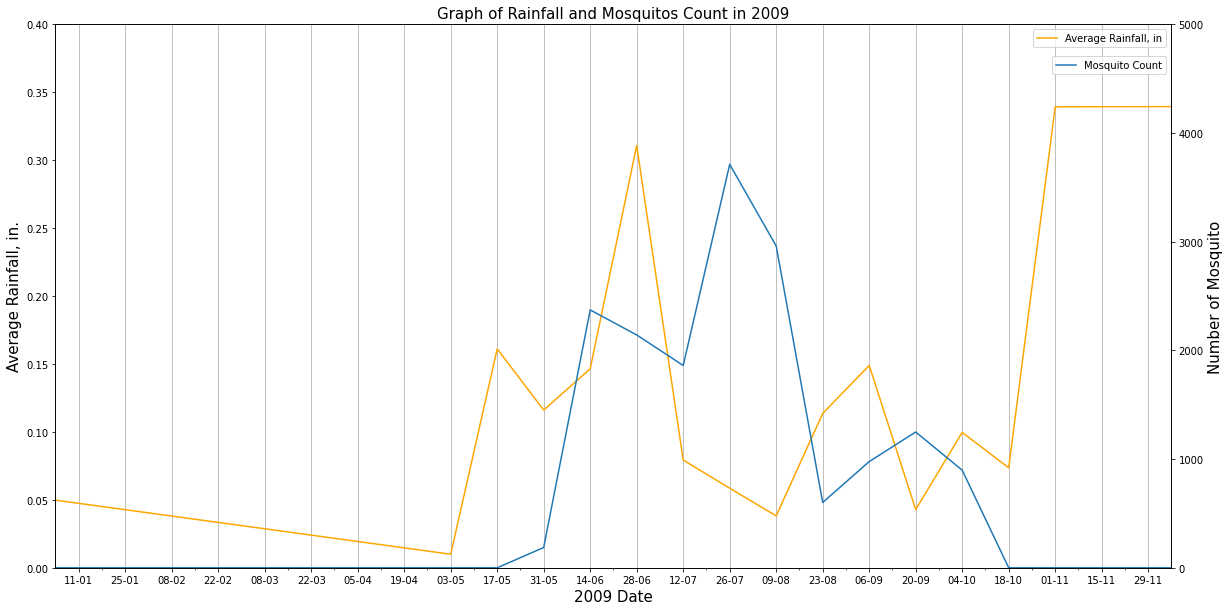

In [10]:
### Checking correlation of raining period and mosquitoes count ###
fig, ax = plt.subplots(figsize=(20,10))

# Plot 1 - Rainfall resampled at 2-week Interval
weather.set_index('Date').resample('2W').mean()['PrecipTotal'].interpolate(method='time').plot(ax=ax, 
                                                                                        color='orange', 
                                                                                        label='Average Rainfall, in')
ax.set_ylabel('Average Rainfall, in', fontsize=12)
ax.set_ylim(0, 0.4)
ax.grid(axis='x')

ax2 = ax.twinx()

# Plot 2 - Number of Mosquitos
train.set_index('Date').resample('2W').sum()['NumMosquitos'].interpolate(method='time').plot(ax=ax2,
                                                                                             label='Mosquito Count')
ax2.set_ylim(0, 5000)
ax2.grid(axis='x')

# Global Setting
timeframe = pd.date_range('2007-06-01', '2013-10-01', freq='2W')
plt.xticks(ticks=timeframe, labels=[x.strftime('%d-%m') for x in timeframe], fontsize=12)
ax.set_title('Graph of Rainfall and Mosquitos Count in 2009', fontsize=15)
ax.set_xlabel('2009 Date', fontsize=15)
ax.set_ylabel('Average Rainfall, in.', fontsize=15)
ax2.set_ylabel("Number of Mosquito", fontsize=15)
plt.xlim('2009-01-01', '2009-12-01')
ax.legend()
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))
plt.show()

When checking the trends of average rainfall and mosquito counts, we can see that it has a similar pattern as the trend of mosquito counts lags behind the pattern average rainfall for around 2 weeks. This coincides with the fact that the life cycle of mosquito Culex Pipiens/Restuans which requires around 2 weeks to hatch.

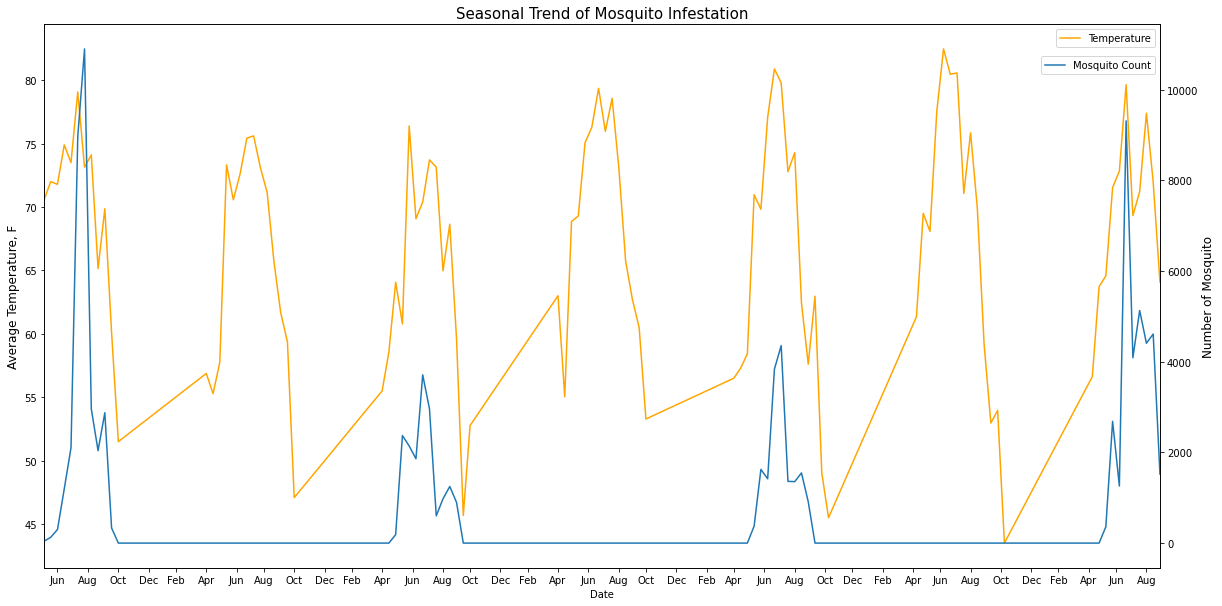

In [11]:
### Temperature Seasonality on Mosquitoes Count ###
fig, ax = plt.subplots(figsize=(20,10),)

# Plot 1 - Temperature resampled at 2-week Interval
weather.set_index('Date').resample('2W').mean()['Tavg'].interpolate(method='time').plot(ax=ax, 
                                                                                        color='orange', 
                                                                                        label='Temperature')
ax.set_ylabel('Average Temperature, F', fontsize=12)
ax.tick_params(axis='x', which='minor', bottom=False)

ax2 = ax.twinx()

# Plot 2 - Number of Mosquitos
train.set_index('Date').resample('2W').sum()['NumMosquitos'].interpolate(method='time').plot(ax=ax2,
                                                                                             label='Mosquito Count')
ax2.set_ylabel('Number of Mosquito', fontsize=12)

# Global Setting
ax.set_title('Seasonal Trend of Mosquito Infestation', fontsize=15)
ax2.set_xlabel('')
timeframe = pd.date_range('2007-06-01', '2013-10-01', freq='2M')
plt.xticks(ticks=timeframe, labels=[x.strftime('%b') for x in timeframe], fontsize=12)

ax.legend()
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, 0.45, 0.5, 0.5))
plt.show()

We can see the frequency of the Average temperature differs when compared with the trend of the mosquito counts. This is mainly due to the fact that the mosquito counts is taken once every 2 years, therefore causing the gap in data during that period.

In [12]:
### Optimal Temperature for Mosquitoes Species ###
def plot_temperature(compound, species=None):
    fig, ax = plt.subplots(figsize=(20,10))

    if species:
        # Plotting one subplot for each species
        for spec in species:

            # Compound data to specifed scale
            temp = train[train['Species']==spec].groupby('Tavg').sum()
            temp = temp.groupby(temp.index // compound).sum().reset_index()[['Tavg', 'NumMosquitos']]
            temp.Tavg = temp.Tavg * compound

            # Replace '0' with 'Others'
            if spec == '0':
                temp.rename(columns={'NumMosquitos': 'Others'}, inplace=True)

            else:
                temp.rename(columns={'NumMosquitos': spec}, inplace=True)

            temp.set_index('Tavg').plot(ax=ax)

    else:
        temp = train.groupby('Tavg').sum()
        temp = temp.groupby(temp.index // compound).sum().reset_index()[['Tavg', 'NumMosquitos']]
        temp.Tavg = temp.Tavg * compound
        temp.set_index('Tavg').plot(ax=ax)
        ax.get_legend().remove()

    # Global Setting
    plt.xlabel('Average Temperature, Farenheit', fontsize=12)
    plt.ylabel('Number of Mosquitoes', fontsize=12)
    plt.title('Number of Mosquitoes at Range of Temperature', fontsize=15)
    plt.show()

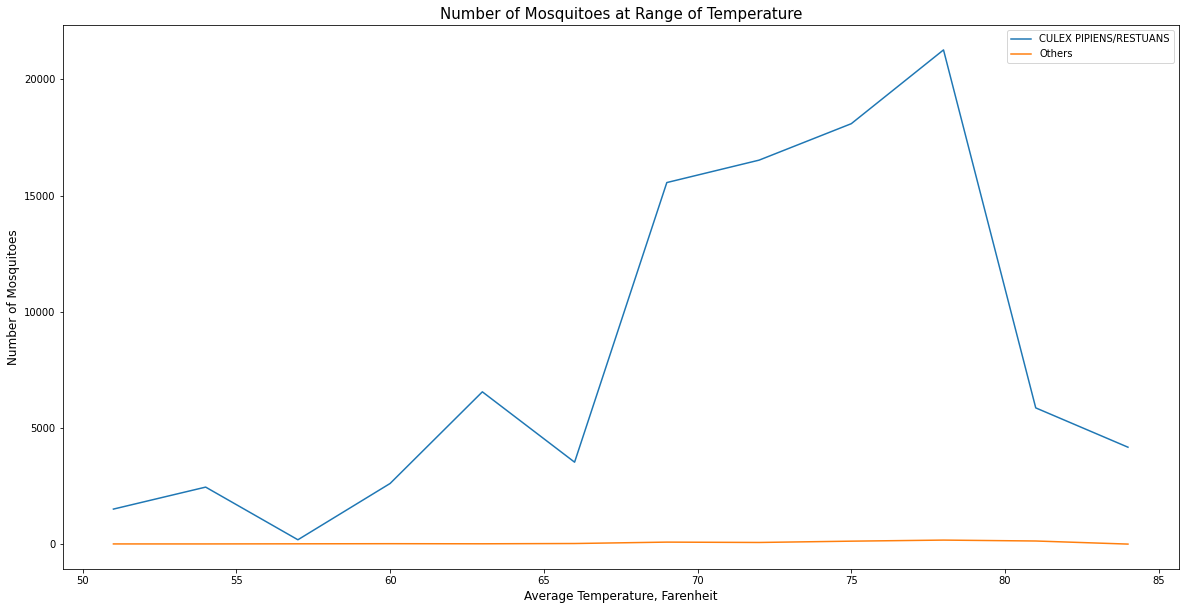

In [13]:
# Plot of optimal temperature range for each species
# compound is of smoothening of temperature range for clear visualisation of temperature range
species = ['CULEX PIPIENS/RESTUANS','0']
plot_temperature(compound=3, species=species)

In [14]:
### Spraying Timeline vs Number Mosquitos ###
def plot_spray(year):

    # Plot Daily Mosquitos Count Sum
    year = str(year)
    plt.figure(figsize=(20,10))
    train.groupby('Date').sum()['NumMosquitos'].plot(marker='o')

    # Plotting all spraying unique time as vertical red line
    for i, date in enumerate(spray.Date.unique()):
        # If-else-loop to prevent multiple legend plotted
        if i==0:
            plt.axvline(date, color='red', linestyle='dashed', label='Spraying Exercise')
        else:
            plt.axvline(date, color='red', linestyle='dashed')

    # Global Setting
    timeframe = pd.date_range(year+'-06-01', year+'-10-01', freq='W')
    plt.xticks(ticks=timeframe, labels=[x.strftime('%Y-%m-%d') for x in timeframe], rotation=30, fontsize=8)
    plt.xlim(year+'-06-01', year+'-10-01')
    plt.xlabel('')
    plt.ylabel('Number of Mosquitoes')
    plt.title('Chicago Mosquitoes Count in ' + year)
    plt.legend()

    plt.show()

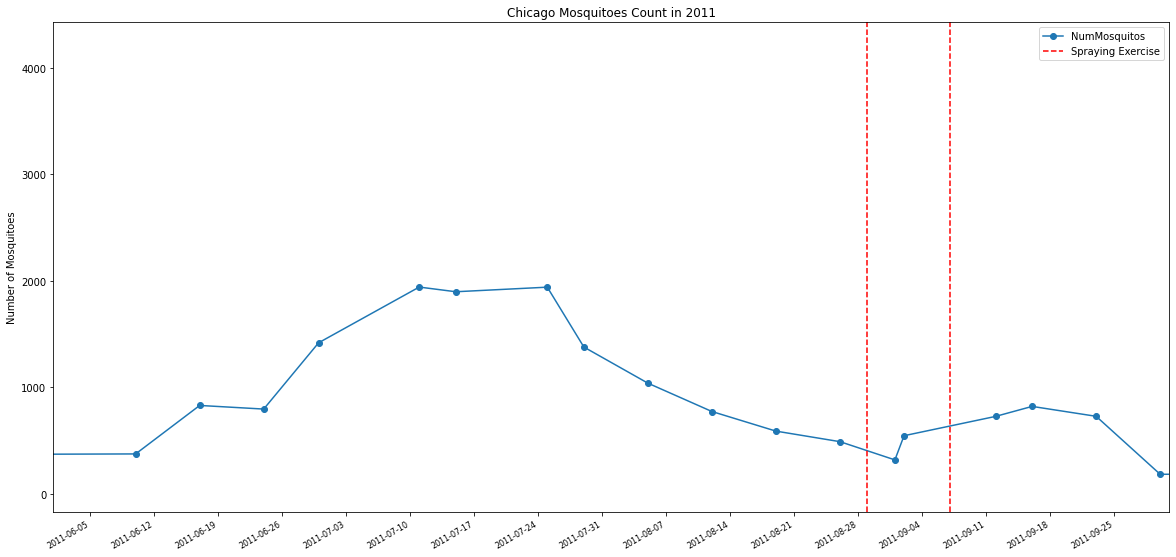

In [15]:
# Spraying plot in 2011
plot_spray(2011)

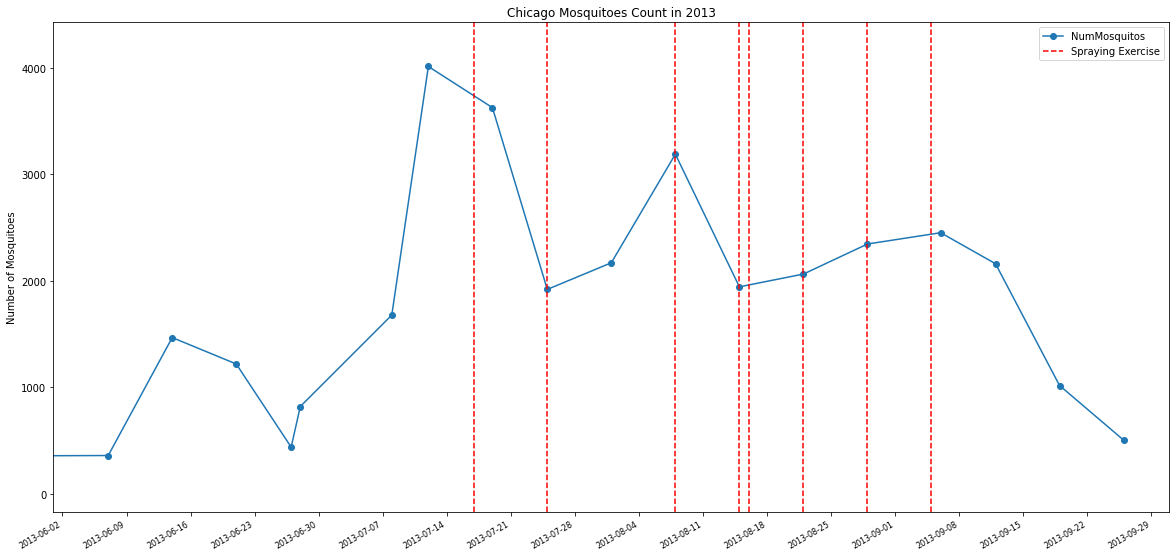

In [16]:
# Spraying plot in 2013
plot_spray(2013)

In [17]:
# Dropping columns that have no information contributing to modeling work
train.drop(['Date','Trap', 'NumMosquitos', 'Latitude', 'Longitude'], axis=1, inplace=True)
train.columns

Index(['Species', 'WnvPresent', 'Sprayed', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'MD', 'BR', 'HZ', 'RA', 'TSRA', 'VCTS', 'FU',
       'TS', 'DZ', 'BCFG', 'FG+', 'MIFG', 'FG', 'SQ', 'SN', 'VCFG', 'GR'],
      dtype='object')

In [18]:
# Get the number of classes in each columns
unique_counts = train.apply(pd.Series.value_counts).notna().sum()

# Getting only continuous variable for correlation study
conti_cols = unique_counts[unique_counts>2].index

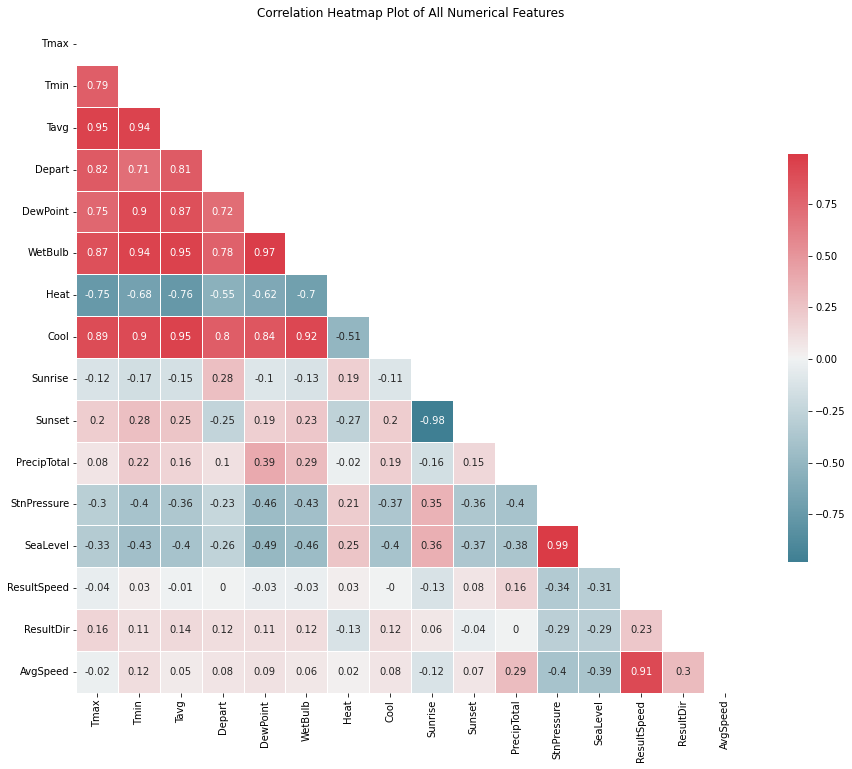

In [19]:
# Plotting correlation heatmap
corr = round(train[conti_cols].corr(),2)
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, square=True, annot=True, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5})
plt.title('Correlation Heatmap Plot of All Numerical Features')
plt.show()

In [20]:
# Loop to remove any collinear variable
correlated_features = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.add(colname)

print("Collinear Columns to drop: ", correlated_features)

Collinear Columns to drop:  {'SeaLevel', 'Cool', 'WetBulb', 'AvgSpeed', 'Tavg', 'Sunset'}


In [21]:
train = train.drop(correlated_features, axis=1)
train.columns

Index(['Species', 'WnvPresent', 'Sprayed', 'Tmax', 'Tmin', 'Depart',
       'DewPoint', 'Heat', 'Sunrise', 'Depth', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'ResultSpeed', 'ResultDir', 'MD', 'BR', 'HZ', 'RA',
       'TSRA', 'VCTS', 'FU', 'TS', 'DZ', 'BCFG', 'FG+', 'MIFG', 'FG', 'SQ',
       'SN', 'VCFG', 'GR'],
      dtype='object')

# Feature Engineering

## One Hot Encoding

In [22]:
train = pd.get_dummies(train, drop_first=True)

test = pd.get_dummies(test, drop_first=True)

train.columns

Index(['WnvPresent', 'Sprayed', 'Tmax', 'Tmin', 'Depart', 'DewPoint', 'Heat',
       'Sunrise', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'ResultSpeed', 'ResultDir', 'MD', 'BR', 'HZ', 'RA', 'TSRA', 'VCTS',
       'FU', 'TS', 'DZ', 'BCFG', 'FG+', 'MIFG', 'FG', 'SQ', 'SN', 'VCFG', 'GR',
       'Species_CULEX PIPIENS/RESTUANS'],
      dtype='object')

# Modelling

## Preprocessing

In [23]:
# train test split
X = train.drop('WnvPresent', axis=1)
y = train['WnvPresent']

round(y.value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

round(y_train.value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

## Model Iterations

Several different models will be performed in iteration to find out the best model. SMOTE will be carried out in each cross-validation to improve the generalization of each model. Common metrics such as Accuracy and AUC-ROC are not used as these models  are insensitive to heavily skewed class. So all model will be tuned based on the recall score instead. 

### Logistic Regression

In [48]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

kf = KFold(n_splits=5, random_state=42, shuffle=True)

print('Validation Score: ', cross_val_score(pipe, X_train, y_train, cv=kf, scoring='recall'))

lr_params = {
    'logreg__solver' : ['liblinear','lbfgs'],
    'logreg__C': np.linspace(0.1, 1, 20)
}

grid_imba = GridSearchCV(pipe, param_grid=lr_params, cv=kf, scoring='recall')

grid_imba.fit(X_train, y_train)

print('\n', grid_imba.best_params_, '\n')

best_model_lr = grid_imba.best_estimator_

lr_train_acc = round(best_model_lr.score(X_train, y_train), 3)
lr_test_acc = round(best_model_lr.score(X_test, y_test), 3)
lr_train_recall = round(recall_score(y_train, best_model_lr.predict(X_train)), 3)
lr_test_recall = round(recall_score(y_test, best_model_lr.predict(X_test)), 3)

print('Train Accuracy Score: ', lr_train_acc)
print('Test Accuracy Score: ', lr_test_acc)
print('\nTrain Recall Score: ', lr_train_recall )
print('Test Recall Score: ', lr_test_recall )

Validation Score:  [0.79310345 0.80246914 0.7875     0.75       0.74390244]

 {'logreg__C': 0.33684210526315794, 'logreg__solver': 'liblinear'} 

Train Accuracy Score:  0.645
Test Accuracy Score:  0.666

Train Recall Score:  0.784
Test Recall Score:  0.723


### PCA

In [49]:
# Instantiate PCA and LogReg
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('sm', SMOTE(random_state=42)),
    ('pca', PCA()),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

print('Validation Score: ', cross_val_score(pipe, X_train, y_train, cv=kf, scoring='recall'))

pipe_params = {
    'pca__n_components': [0.1, 0.25, 0.5, 0.75, 1],
    'pca__tol': [0.5, 0.75, 1],
    'logreg__C': np.linspace(0.1, 1, 10),
    'logreg__solver' : ['liblinear','lbfgs']
}

grid_pipe = GridSearchCV(pipe, param_grid=pipe_params, cv=kf, scoring='recall')
grid_pipe.fit(X_train, y_train)

print('\n', grid_pipe.best_params_, '\n')

best_model_lr_pca = grid_pipe.best_estimator_

pca_train_acc = round(best_model_lr_pca.score(X_train, y_train), 3)
pca_test_acc = round(best_model_lr_pca.score(X_test, y_test), 3)
pca_train_recall = round(recall_score(y_train, best_model_lr_pca.predict(X_train)), 3)
pca_test_recall = round(recall_score(y_test, best_model_lr_pca.predict(X_test)), 3)

print('Train Accuracy Score: ', pca_train_acc)
print('Test Accuracy Score: ', pca_test_acc)
print('Train Recall Score: ', pca_test_recall )
print('Test Recall Score: ', pca_test_recall)

Validation Score:  [0.79310345 0.80246914 0.7875     0.75       0.74390244]

 {'logreg__C': 0.1, 'logreg__solver': 'liblinear', 'pca__n_components': 0.75, 'pca__tol': 0.5} 

Train Accuracy Score:  0.617
Test Accuracy Score:  0.615
Train Recall Score:  0.703
Test Recall Score:  0.703


###  K Nearest Neighbors

In [50]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

#set pipe params
pipe_params = {
    'knn__n_neighbors' : [3,5,7,10],
    'knn__weights' : ['uniform','distance'],
    'knn__p': [1,2]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='recall')
#fit model
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_

knn_train_acc = round(best_knn.score(X_train, y_train), 3)
knn_test_acc = round(best_knn.score(X_test, y_test), 3)
knn_train_recall = round(recall_score(y_train, best_knn.predict(X_train)), 3)
knn_test_recall = round(recall_score(y_test, best_knn.predict(X_test)), 3)

print('\n', gs.best_params_, '\n')
print('Train Accuracy Score: ', knn_train_acc)
print('Test Accuracy Score: ', knn_test_acc)
print('\nTrain Recall Score: ', knn_train_recall)
print('Test Recall Score: ', knn_test_recall)


 {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'} 

Train Accuracy Score:  0.767
Test Accuracy Score:  0.783

Train Recall Score:  0.714
Test Recall Score:  0.703


### Random Forest Classifier

In [51]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, bootstrap=True))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100,150,250],
    'rf__max_depth': [1,3,9,10]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

rfc_train_acc = round(best_rf.score(X_train, y_train), 3)
rfc_test_acc = round(best_rf.score(X_test, y_test), 3)
rfc_train_recall = round(recall_score(y_train, best_rf.predict(X_train)), 3)
rfc_test_recall = round(recall_score(y_test, best_rf.predict(X_test)), 3)

print('\n', gs.best_params_, '\n')
print('Train Accuracy Score: ', rfc_train_acc)
print('Test Accuracy Score: ', rfc_test_acc)
print('\nTrain Recall Score: ', rfc_train_recall)
print('Test Recall Score: ', rfc_test_recall)


 {'rf__max_depth': 10, 'rf__n_estimators': 100} 

Train Accuracy Score:  0.734
Test Accuracy Score:  0.751

Train Recall Score:  0.811
Test Recall Score:  0.752


### XGBoost Classifier

In [52]:
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('xgbclassifier', XGBClassifier(random_state=42, verbosity=1, n_jobs=-1, eval_metric="logloss",use_label_encoder=False))
])
print('Validation Score: ', cross_val_score(pipe, X_train, y_train, cv=kf, scoring='recall'))

xgb_params = {  'xgbclassifier__learning_rate': [0.1],
                'xgbclassifier__max_depth': [3],
                'xgbclassifier__min_child_weight': [5],
                'xgbclassifier__gamma': [0.2],
                'xgbclassifier__subsample': [0.8],
                'xgbclassifier__scale_pos_weight': [1],
                'xgbclassifier__n_estimators': [200]}

grid_imba = GridSearchCV(pipe, param_grid=xgb_params, cv=kf, scoring='recall')

grid_imba.fit(X_train, y_train)

print('\n', grid_imba.best_params_, '\n')

best_model_xgb = grid_imba.best_estimator_

xgb_train_acc = round(best_model_xgb.score(X_train, y_train), 3)
xgb_test_acc = round(best_model_xgb.score(X_test, y_test), 3)
xgb_train_recall = round(recall_score(y_train, best_model_xgb.predict(X_train)), 3)
xgb_test_recall = round(recall_score(y_test, best_model_xgb.predict(X_test)), 3)

print('Train Accuracy Score: ', xgb_train_acc)
print('Test Accuracy Score: ', xgb_test_acc)
print('\nTrain Recall Score: ', xgb_train_recall)
print('Test Recall Score: ', xgb_test_recall)

Validation Score:  [0.77011494 0.85185185 0.7375     0.73611111 0.79268293]

 {'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__scale_pos_weight': 1, 'xgbclassifier__subsample': 0.8} 

Train Accuracy Score:  0.744
Test Accuracy Score:  0.759

Train Recall Score:  0.801
Test Recall Score:  0.762


In [54]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Logistic Regression','Logistic Regression with PCA','K Nearest Neighbors','Random Forest','XGBoost'],
    'Training Accuracy' : [lr_train_acc, pca_train_acc, knn_train_acc, rfc_train_acc, xgb_train_acc],
    'Test Accuracy' : [lr_test_acc, pca_test_acc, knn_test_acc, rfc_test_acc, xgb_test_acc],
    'Training Recall':[lr_train_recall, pca_train_recall, knn_train_recall, rfc_train_recall, xgb_train_recall],
    'Test Recall' : [lr_test_recall, pca_test_recall, knn_test_recall, rfc_test_recall, xgb_test_recall]
})

model_df

,Model,Training Accuracy,Test Accuracy,Training Recall,Test Recall
0,Logistic Regression,0.645,0.666,0.784,0.723
1,Logistic Regression with PCA,0.617,0.615,0.652,0.703
2,K Nearest Neighbors,0.767,0.783,0.714,0.703
3,Random Forest,0.734,0.751,0.811,0.752
4,XGBoost,0.744,0.759,0.801,0.762
